In [2]:
import sys
if not '../..' in sys.path:
    sys.path.append('../..')
    sys.path.append('..')
from analysis import collection, analysis, emg, plot, model
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import patches, lines
from pathlib import Path
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, LeaveOneOut
from sklearn.linear_model import LinearRegression, Ridge
from joblib import dump, load
from analysis.offsets import offsets
from scipy.stats import multivariate_normal

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'axes.labelsize': 16})
mpl.rcParams.update({'figure.figsize': (16*0.8,9*0.8)})
mpl.rcParams.update({'axes.facecolor': "white"})
mpl.rcParams.update({'lines.marker': "+"})
mpl.rcParams.update({'lines.linestyle': ""})
mpl.rcParams.update({"axes.spines.left":   True})
mpl.rcParams.update({"axes.spines.bottom": True})
mpl.rcParams.update({"axes.spines.top":    False})
mpl.rcParams.update({"axes.spines.right":  False})

image_path = Path("/Users/spencer/phd/phd/images/more_results/manifold/")

%matplotlib inline

ImportError: cannot import name 'collection' from 'analysis' (/Users/spencer/phd/phd/analysis/notebooks/../../analysis/__init__.py)

## how fine-grained are the features of the covariance? (this is similar to rank)

In [3]:
subjects = analysis.load_subjects()

NameError: name 'analysis' is not defined

In [ ]:
best_subject_idxs = [0, 6, 15, 16, 27, 29, 35, 37, 42]
best_color = ["g" if i in best_subject_idxs else "k" for i in range(46)]

### hits

In [5]:
subject_hits = []
for subject in subjects:
    hits = 0
    for s in subject.tasks["center_hold"].sorted_sessions():
        for t in s.sorted_trials():
            if t.outcome == "Hit":
                hits += 1
    subject_hits.append(hits)
hit_fractions = [sh/540 for sh in subject_hits]

In [7]:
def effective_rank(M, variance_cutoff=0.9):
    U, S, V = np.linalg.svd(M)
    variance_captured = S / S.sum()
    cum_variance_captured = variance_captured.cumsum()
    return (cum_variance_captured < variance_cutoff).sum() + 1

def variance_captured(M, n_components=5):
    U, S, V = np.linalg.svd(M)
    variance_captured = S / S.sum()
    cum_variance_captured = variance_captured.cumsum()
    return cum_variance_captured[n_components-1]

def top_component_variance(M,n_components=1):
    U, S, V = np.linalg.svd(M)
    return (S[:n_components] / S.sum()).sum()


In [8]:
# test
x = np.diag([0.9,0.1,0.1,0.01,0.01,0.01,0.01,0.01,0.01,0.01])
print(effective_rank(x) == 3)
print(variance_captured(x,3))

x = np.diag([0.9,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01])
print(effective_rank(x) == 1)
print(variance_captured(x,1))

x = np.diag([0.9] * 10)
print(effective_rank(x) == 10)
print(variance_captured(x,3))

True
0.9401709401709402
True
0.9090909090909091
True
0.30000000000000004


## experimenting with "difference of gaussians" blurring as a measure of "subspace confinement"

This would allow us to test whether subspace confinement correlates with performance

In [61]:
from scipy.ndimage import gaussian_filter

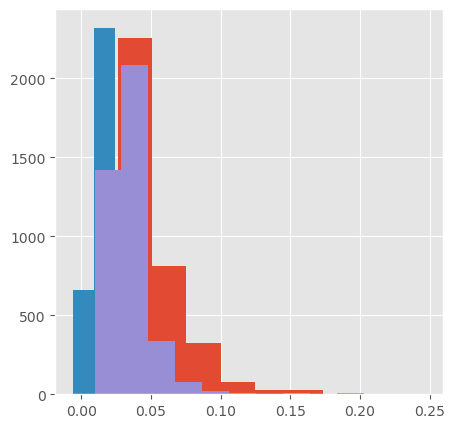

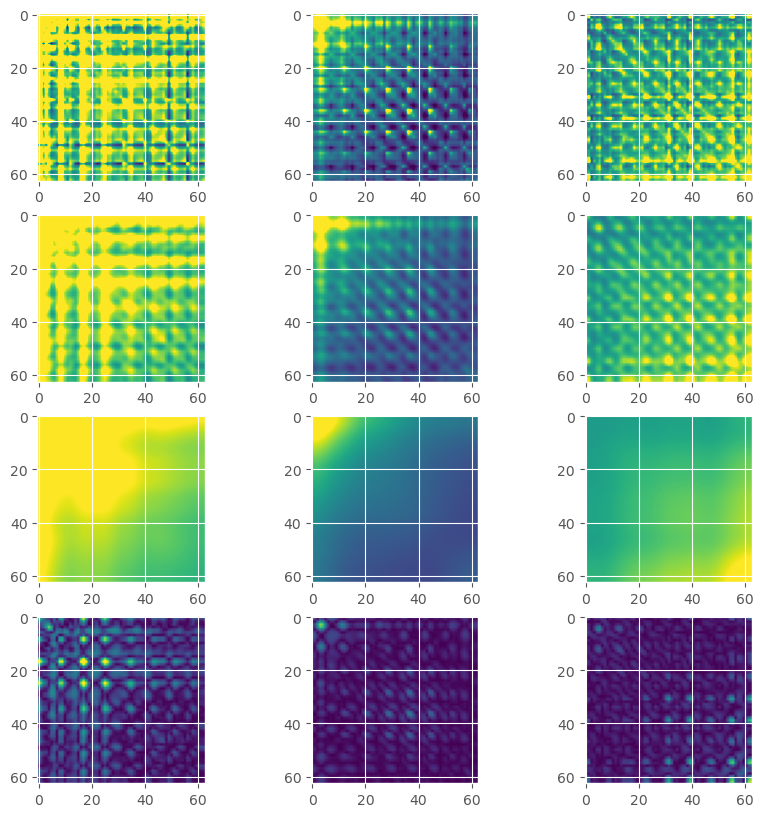

In [62]:
# visualize gaussian blurring

# uniform_image = np.random.uniform(0,1,size=(64,64))
# uniform_image += uniform_image.T
# uniform_image *= covariance.sum() / uniform_image.sum()

# gaussian_image = np.abs(np.random.normal(1,1,size=(64,64)))
# gaussian_image += gaussian_image.T
# gaussian_image *= covariance.sum() / gaussian_image.sum()

# print(difference_of_gaussians(covariance), difference_of_gaussians(uniform_image), difference_of_gaussians(gaussian_image))

# # 

# plt.figure()
# plt.hist(uniform_image.ravel())

# plt.figure()
# plt.imshow(uniform_image,vmax=0.1)

# small_blurred = gaussian_filter(uniform_image, sigma=2)
# plt.figure()
# plt.imshow(small_blurred,vmax=0.1)

# large_blurred = gaussian_filter(uniform_image, sigma=10)
# plt.figure()
# plt.imshow(large_blurred,vmax=0.1)

# print(uniform_image.sum(), small_blurred.sum(), large_blurred.sum())

# # 

# plt.figure()
# plt.hist(gaussian_image.ravel())

# plt.figure()
# plt.imshow(gaussian_image,vmax=0.1)

# small_blurred = gaussian_filter(gaussian_image, sigma=2)
# plt.figure()
# plt.imshow(small_blurred,vmax=0.1)

# large_blurred = gaussian_filter(gaussian_image, sigma=10)
# plt.figure()
# plt.imshow(large_blurred,vmax=0.1)

# print(gaussian_image.sum(), small_blurred.sum(), large_blurred.sum())

# # 

def drop_channel_56(a):
    assert a.shape == (64,64)
    return np.delete(np.delete(a,56,0),56,1)

fig, hist_ax = plt.subplots(1,1,figsize=(5,5))
fig, cov_axes = plt.subplots(4,3,figsize=(10,10))

for i in range(3):

    covariance = drop_channel_56(subject_covs[i])
    # covariance /= (covariance.sum() / 100)

    hist_ax.hist(covariance.ravel())

    cov_axes[0,i].imshow(covariance,vmin=0,vmax=0.05)

    small_blurred = gaussian_filter(covariance, sigma=1, order=0, mode='mirror')
    cov_axes[1,i].imshow(small_blurred,vmin=0,vmax=0.05)

    large_blurred = gaussian_filter(covariance, sigma=4, order=0, mode='mirror')
    cov_axes[2,i].imshow(large_blurred,vmin=0,vmax=0.05)

    cov_axes[3,i].imshow(np.abs(large_blurred-small_blurred),vmin=0,vmax=0.05)


## higher DoG ~ less uniformity! (more "difficult" to blur)

In [85]:
def difference_of_gaussians(a, small_sigma=1, large_sigma=4):
    # normalize the array for comparison between arrays?
    small_blurred = gaussian_filter(a, sigma=small_sigma,order=0,mode="mirror")
    large_blurred = gaussian_filter(a, sigma=large_sigma,order=0,mode="mirror")
    return np.sum(np.abs(large_blurred - small_blurred))

In [86]:
diff_of_gaussians = [difference_of_gaussians(drop_channel_56(cov)) for cov in subject_covs]

In [1]:
def remove_outliers(array, outlier_value_array, n_outliers, mode):
    # argsort sorts low to high
    if mode=="high":
        # clip from the high side
        idxs = np.argsort(outlier_value_array)[::-1][:n_outliers]
        if n_outliers > 0:
            print(f"Removing outliers with indices {idxs}")
        return np.delete(array, idxs)
    elif mode=="low":
        # clip from the low side
        idxs = np.argsort(outlier_value_array)[:n_outliers]
        if n_outliers > 0:
            print(f"Removing outliers with indices {idxs}")
        return np.delete(array, idxs)
    else: 
        raise ValueError("Mode param must be 'high' or 'low'")

hf_no = remove_outliers(hit_fractions, diff_of_gaussians, 0, "high")
dg_no = remove_outliers(diff_of_gaussians, diff_of_gaussians, 0, "high")

plt.scatter(hf_no, dg_no, marker="o",c=remove_outliers(best_color, diff_of_gaussians, 3, "high"))
result = linear_fit(hf_no, dg_no)
plot_linear_fit(np.linspace(hf_no.min(),hf_no.max(),100),result,plt.gca())
plt.legend()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (4074792341.py, line 18)

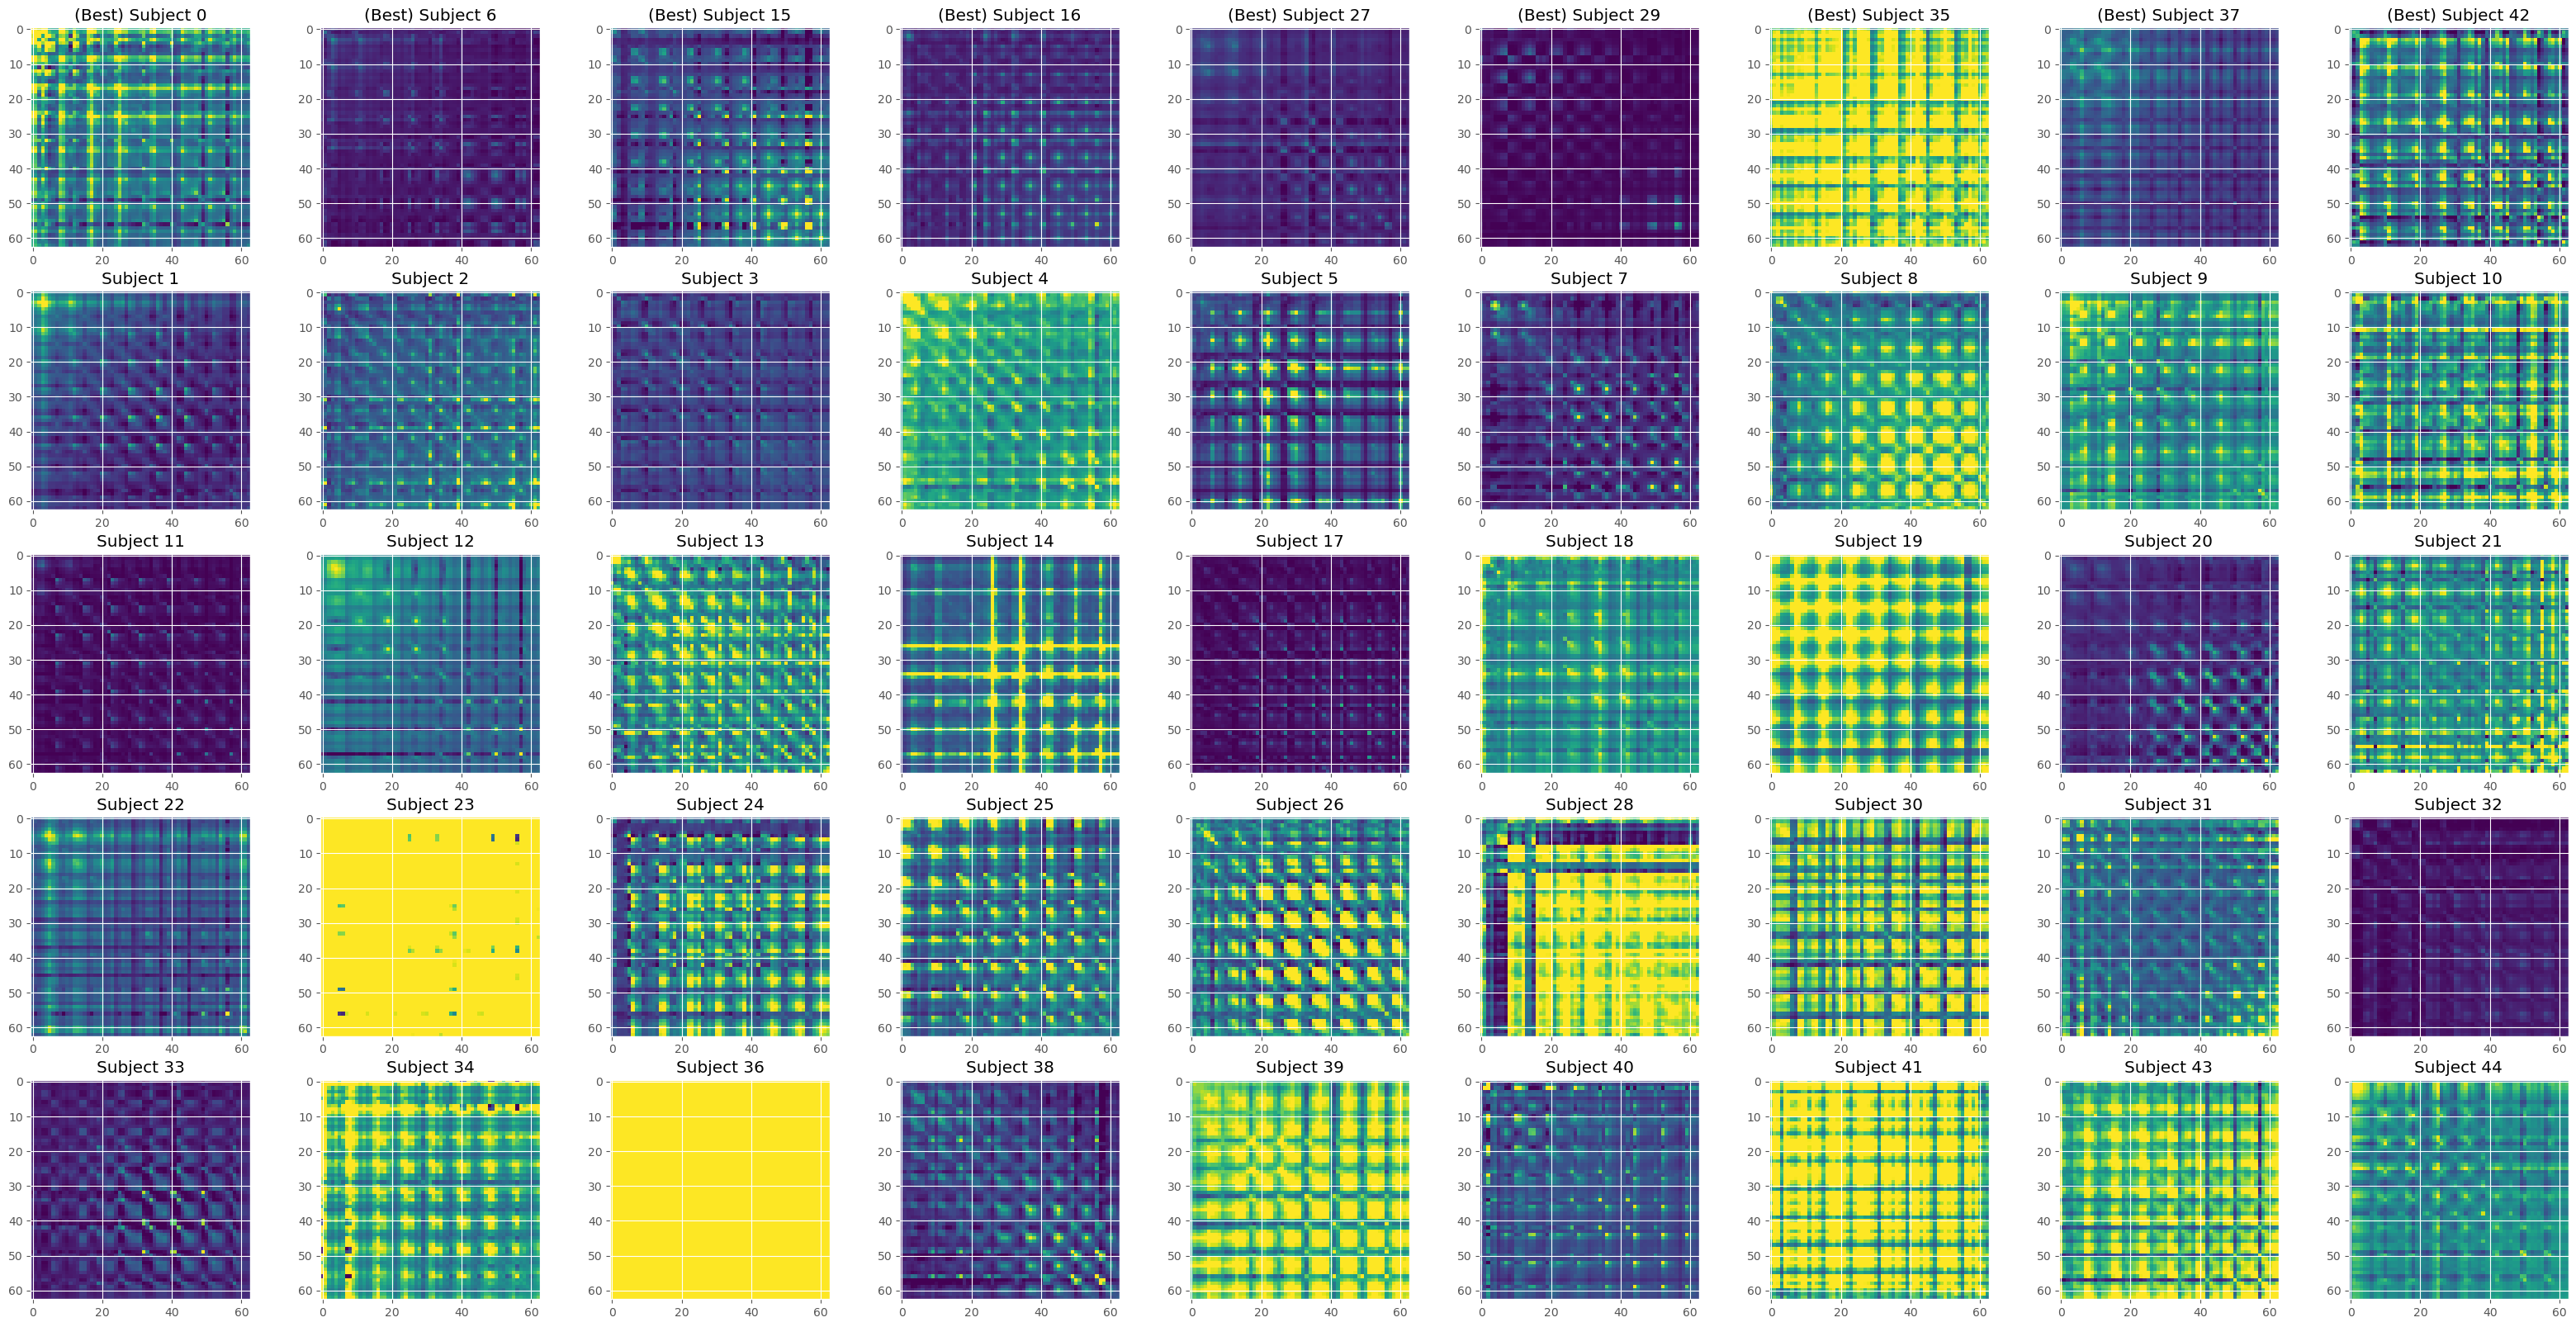

In [67]:
fig, axes = plt.subplots(5,9,figsize=(40,20))
axes = axes.ravel()

# first 9 axes
for axis_i, ax in enumerate(axes[:9]):
    ax.imshow(drop_channel_56(subject_covs[best_subject_idxs[axis_i]]),vmin=0,vmax=0.1)
    ax.set_title(f"(Best) Subject {best_subject_idxs[axis_i]}")

# rest of the axes, skipping best subjects
cov_counter = 0
for axis_i, ax in enumerate(axes[9:45]):
    while cov_counter in best_subject_idxs:
        cov_counter += 1
    ax.imshow(drop_channel_56(subject_covs[cov_counter]),vmin=0,vmax=0.1)
    ax.set_title(f"Subject {cov_counter}")
    cov_counter += 1


# ALL BLOCKS

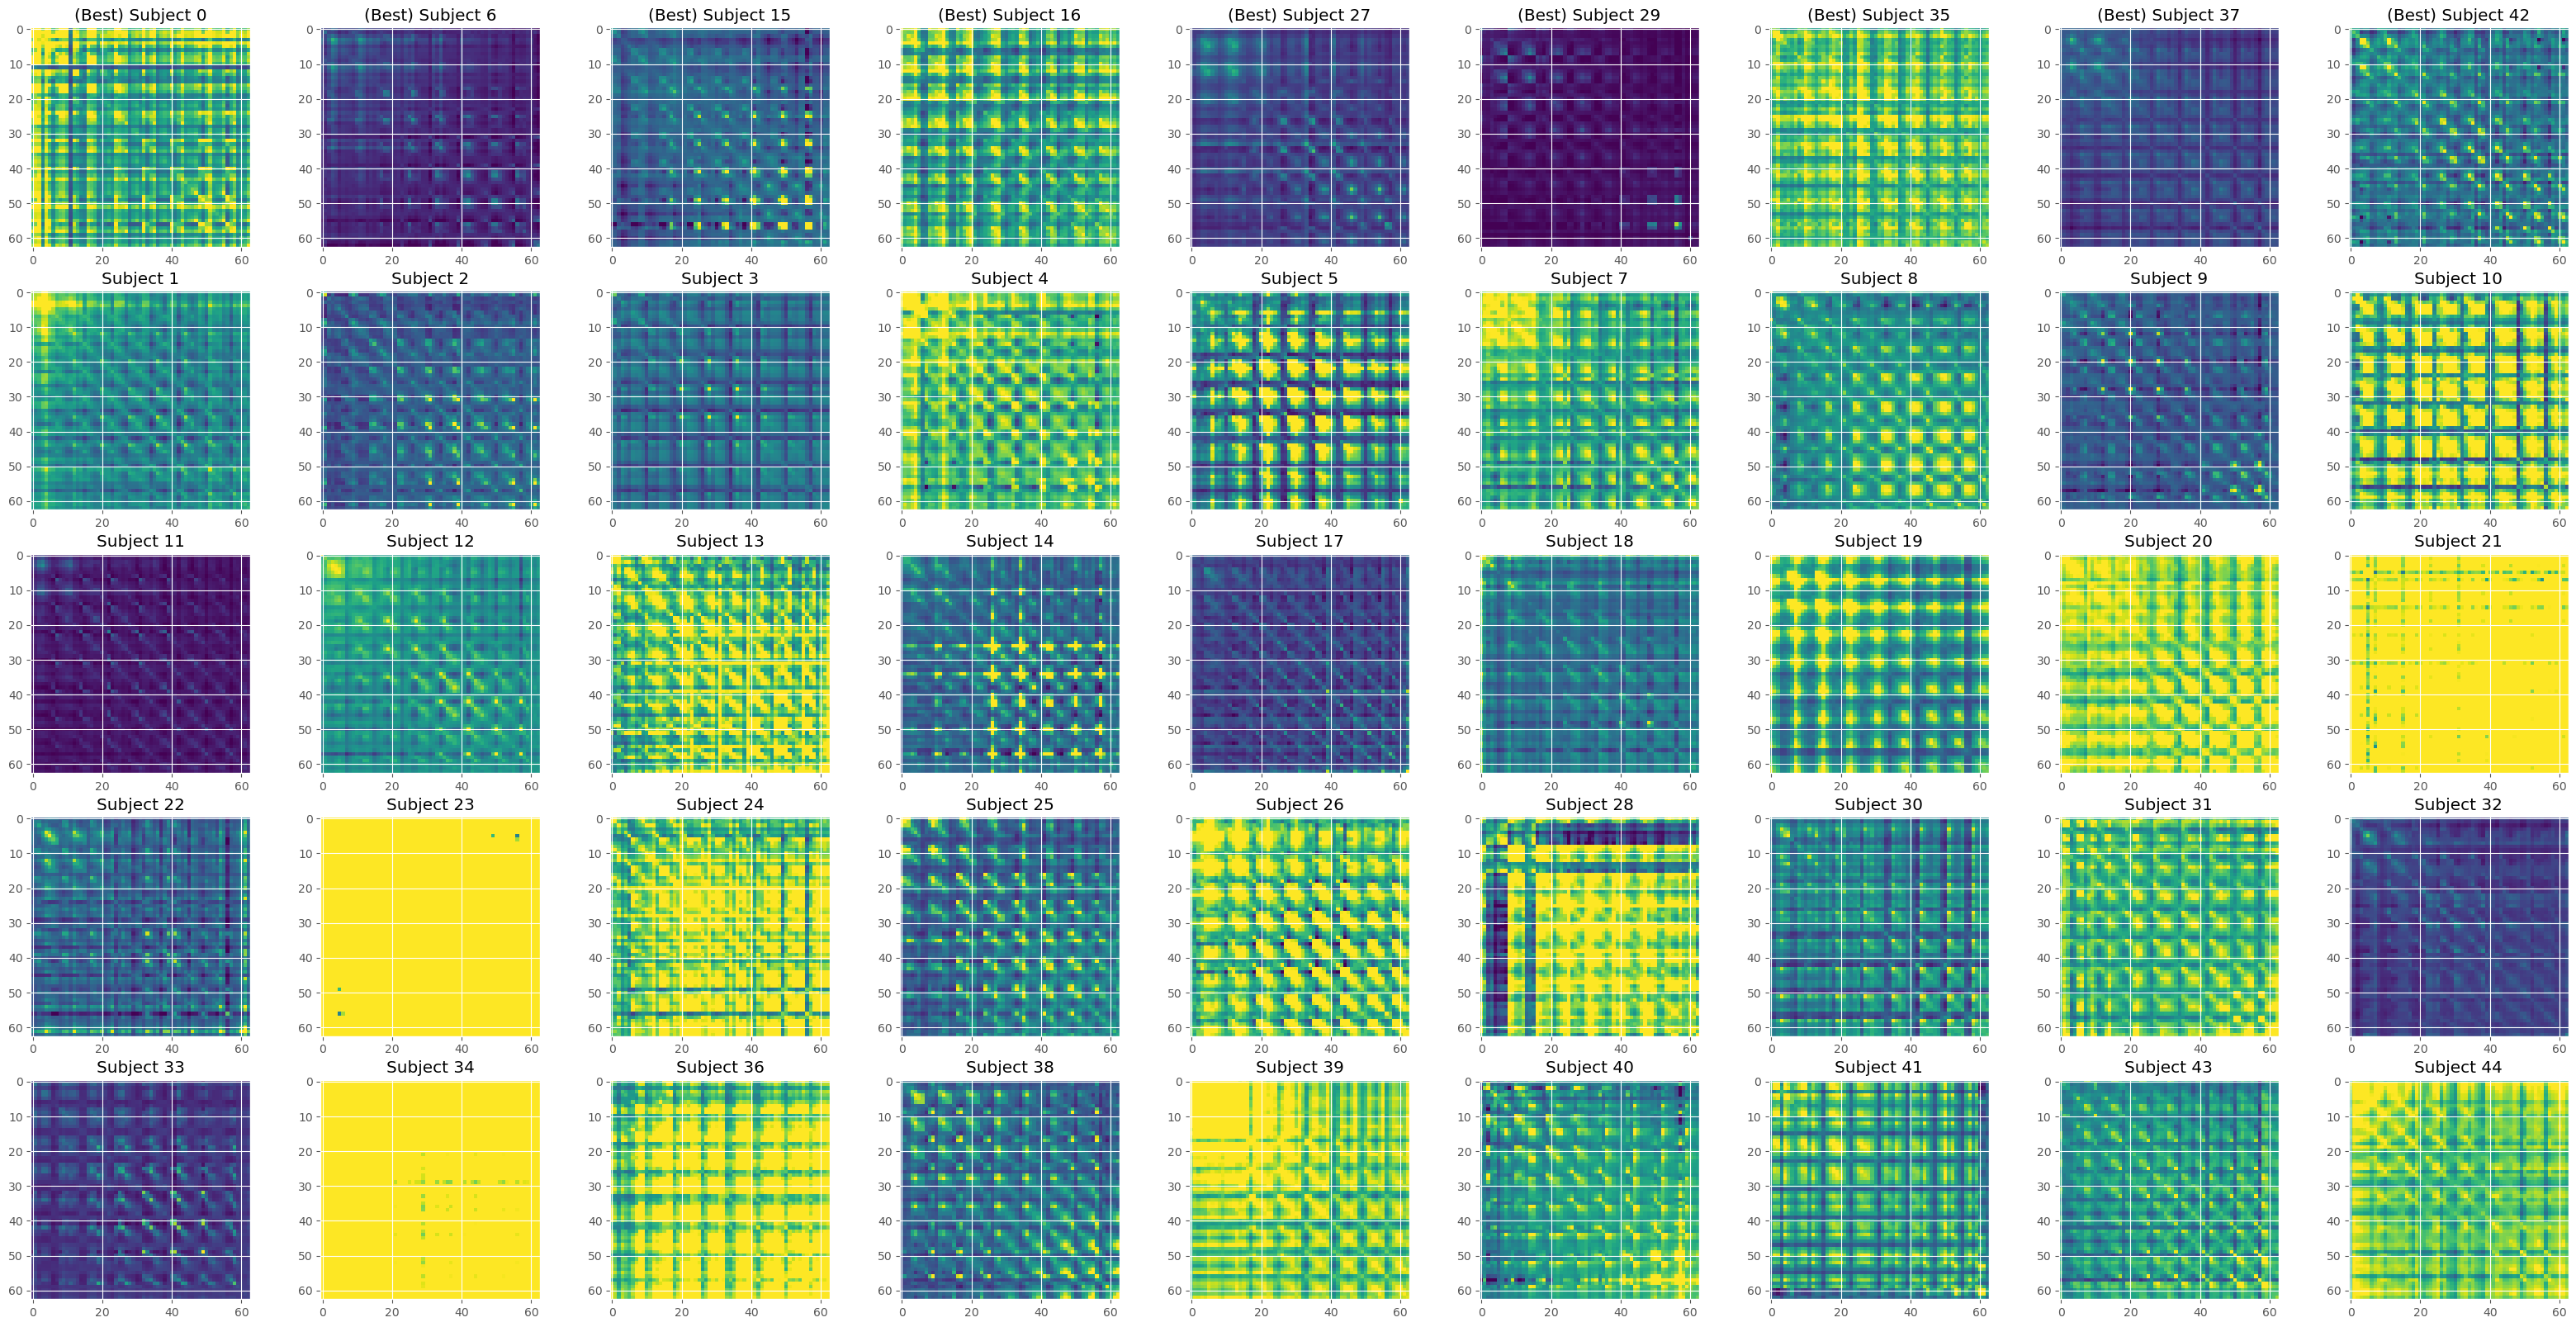

In [51]:
fig, axes = plt.subplots(5,9,figsize=(40,20))
axes = axes.ravel()

# first 9 axes
for axis_i, ax in enumerate(axes[:9]):
    ax.imshow(drop_channel_56(subject_covs[best_subject_idxs[axis_i]]),vmin=0,vmax=0.1)
    ax.set_title(f"(Best) Subject {best_subject_idxs[axis_i]}")

# rest of the axes, skipping best subjects
cov_counter = 0
for axis_i, ax in enumerate(axes[9:45]):
    while cov_counter in best_subject_idxs:
        cov_counter += 1
    ax.imshow(drop_channel_56(subject_covs[cov_counter]),vmin=0,vmax=0.1)
    ax.set_title(f"Subject {cov_counter}")
    cov_counter += 1


In [68]:
subject_var_cov = np.var([cov.ravel() for cov in subject_covs], axis=1)

Removing outliers with indices [36 23 34 14]
Removing outliers with indices [36 23 34 14]
Removing outliers with indices [36 23 34 14]


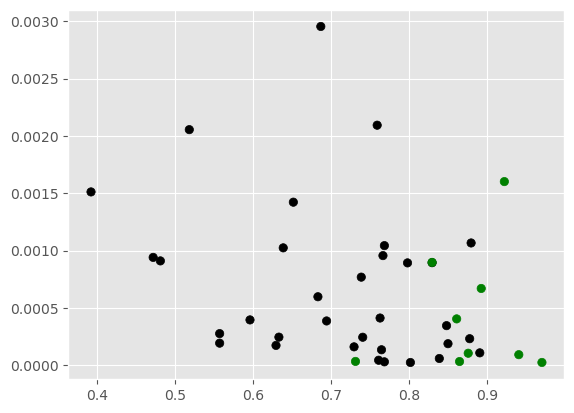

In [77]:
n_outliers = 4
plt.scatter(remove_outliers(hit_fractions,subject_var_cov,n_outliers,"high"), remove_outliers(subject_var_cov,subject_var_cov,n_outliers,"high"),marker="o",c=remove_outliers(best_color,subject_var_cov,n_outliers,"high"))


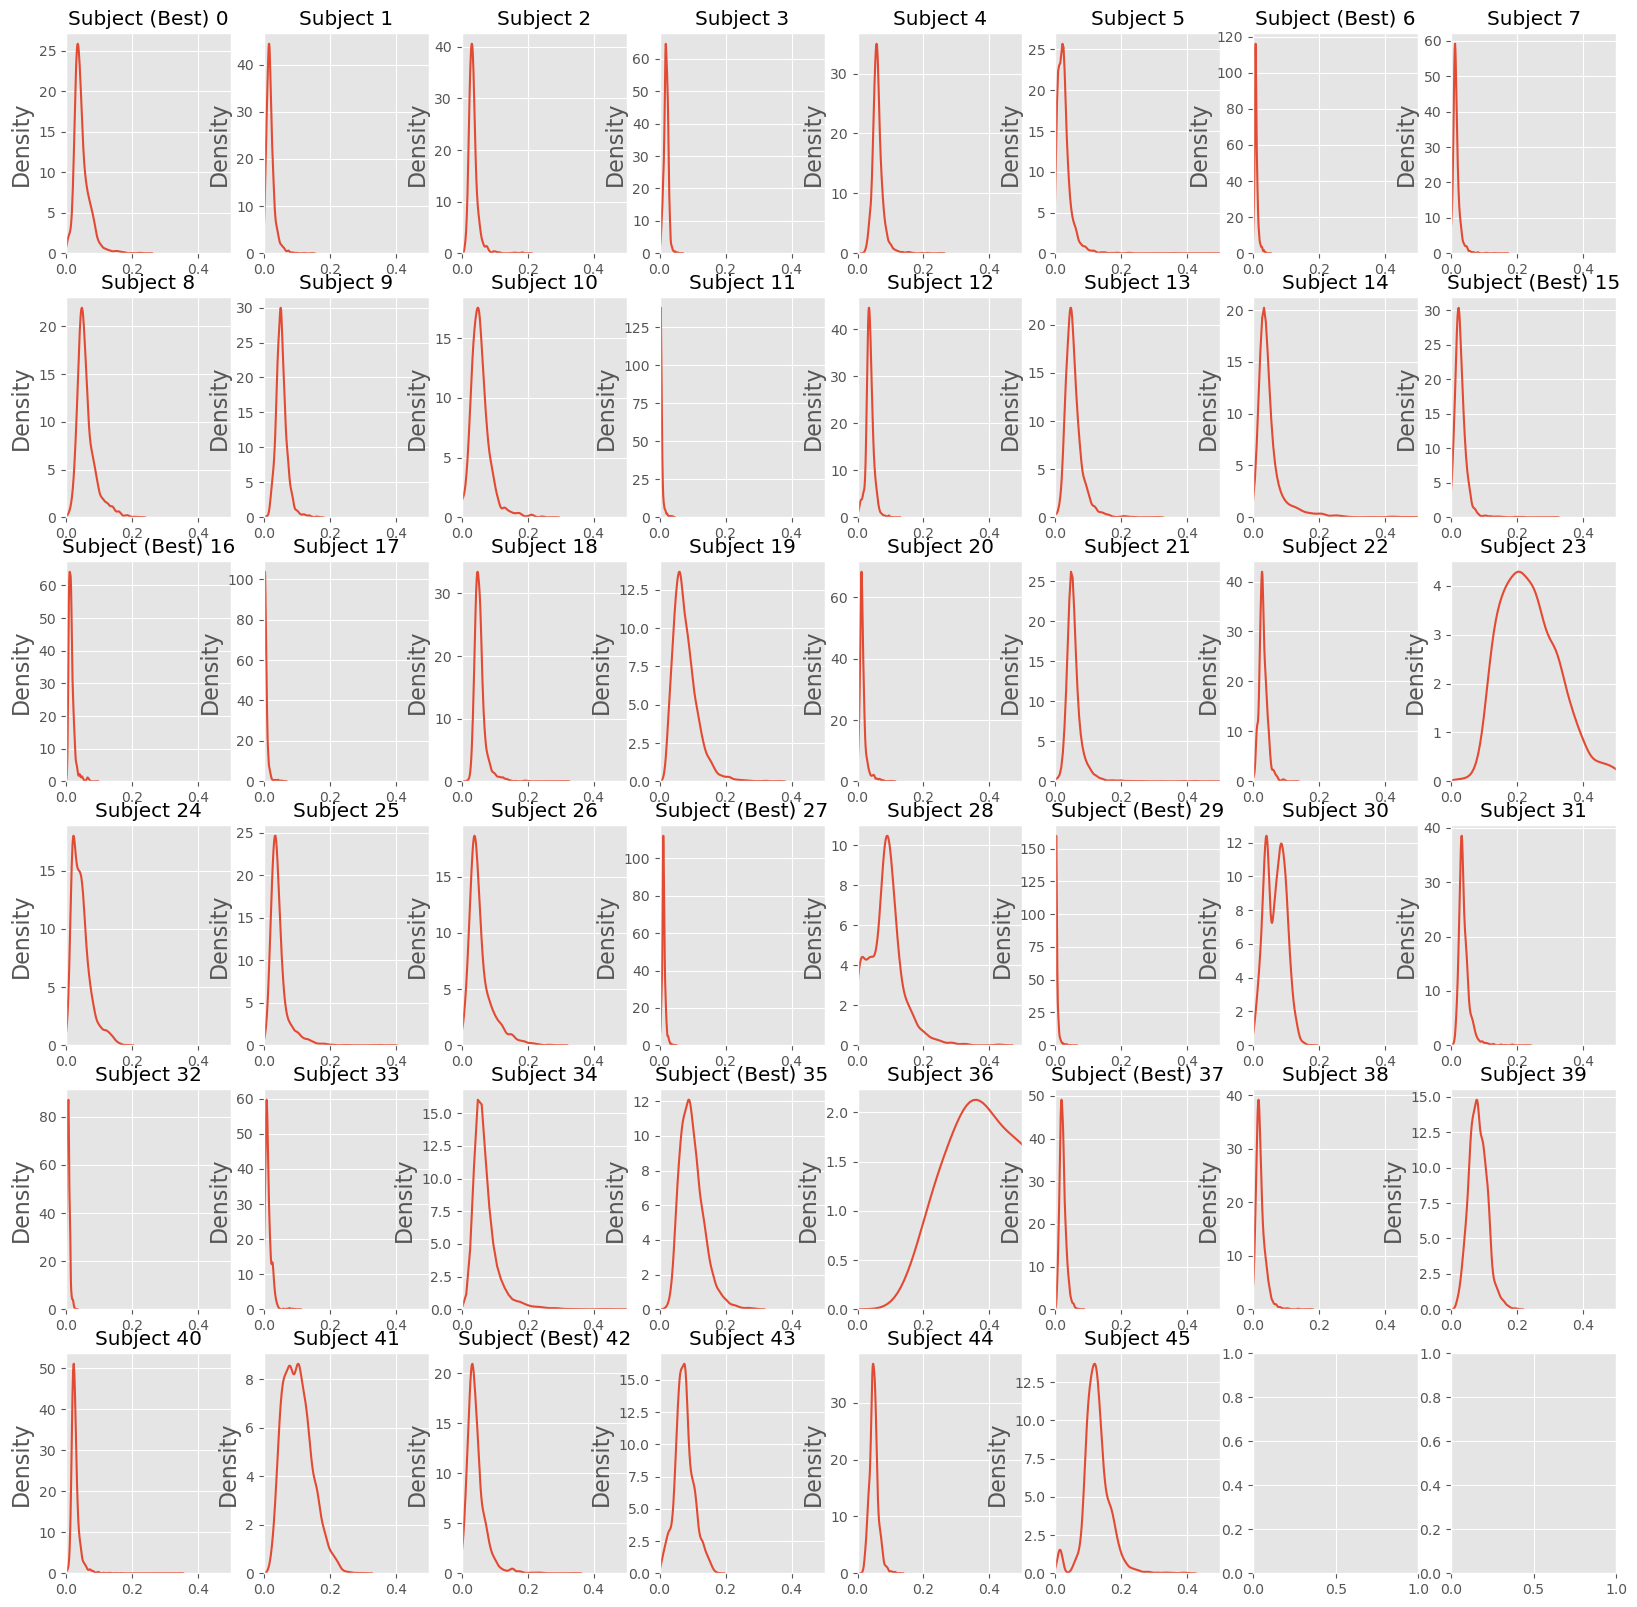

In [71]:
fig, hist_ax = plt.subplots(6,8,figsize=(20,20))
hist_ax = hist_ax.ravel()
# outliers here are: 3, 46
for i, cov in enumerate(subject_covs):
    sns.kdeplot(drop_channel_56(cov).ravel(),ax=hist_ax[i])
    if i in best_subject_idxs:
        hist_ax[i].set_title(f"Subject (Best) {i}")
    else:
        hist_ax[i].set_title(f"Subject {i}")
    hist_ax[i].set_xlim([0,0.5])

## total variance ~ hits? 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Removing outliers with indices [36 23]
Removing outliers with indices [36 23]


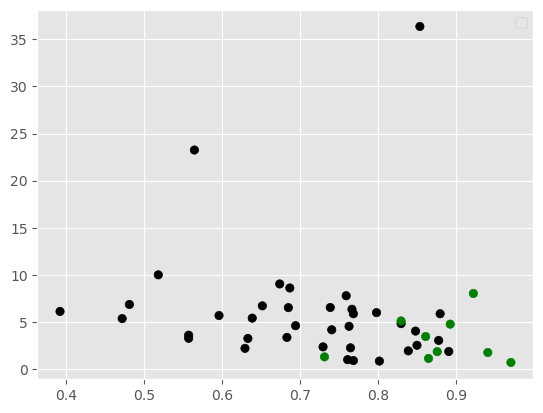

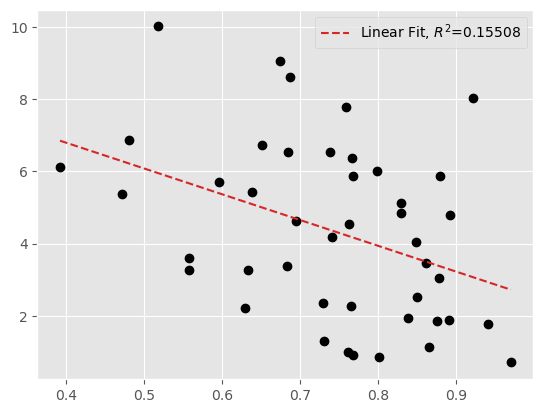

In [78]:
total_var = np.array([np.trace(cov) for cov in subject_covs])

plt.scatter(np.array(hit_fractions), np.array(total_var),marker="o",c=np.array(best_color))
result = linear_fit(hit_fractions, total_var)
# plot_linear_fit(np.linspace(min(hit_fractions),max(hit_fractions),100),result,plt.gca())
plt.legend()

hf_no = remove_outliers(hit_fractions, hit_fractions, 0, "low")
tv_no = remove_outliers(total_var, hit_fractions, 0, "low")
hf_no = remove_outliers(hf_no, tv_no, 2, "high")
tv_no = remove_outliers(tv_no, tv_no, 2, "high")

plt.figure()
plt.plot(hf_no, tv_no, "ko")
result = linear_fit(hf_no, tv_no)
plot_linear_fit(np.linspace(hf_no.min(),hf_no.max(),100),result,plt.gca())
plt.legend()